<a href="https://colab.research.google.com/github/1sheca/Wheat-Crop-Disease-Prediction/blob/main/Wheat_Crop_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gdown
import zipfile
import os

# Download the file from the URL
url = 'https://drive.google.com/uc?id=1sYkXK9p9HHXFTLf99_5Yx16MbuUyC6f4'
output = '/content/wheat_dataset.zip'
gdown.download(url, output, quiet=False)

# Define the directory where you want to extract the contents of the zip file
extracted_dir_path = '/content/wheat_dataset'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Check the contents of the extracted directory
print("Contents of the extracted directory:")
print(os.listdir(extracted_dir_path))


Downloading...
From (original): https://drive.google.com/uc?id=1sYkXK9p9HHXFTLf99_5Yx16MbuUyC6f4
From (redirected): https://drive.google.com/uc?id=1sYkXK9p9HHXFTLf99_5Yx16MbuUyC6f4&confirm=t&uuid=c0c4066c-676f-4f33-8980-8ea6b5fcaf5f
To: /content/wheat_dataset.zip
100%|██████████| 508M/508M [00:15<00:00, 33.1MB/s]


Contents of the extracted directory:
['wheat_data', '__MACOSX']


Class Names:
['Brown_rust', 'Healthy', 'Yellow_rust']


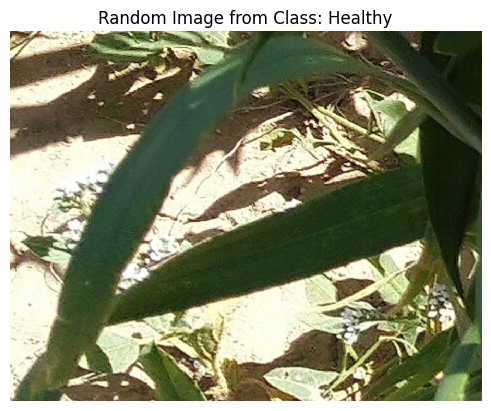

Found 2944 images belonging to 3 classes.
Found 735 images belonging to 3 classes.
Class Indices:
{'Brown_rust': 0, 'Healthy': 1, 'Yellow_rust': 2}


In [13]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the directory containing the dataset
dataset_dir = '/content/wheat_dataset/wheat_data'

# Filter out non-directory items
class_names = [item for item in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, item))]

# Print the filtered class names
print("Class Names:")
print(class_names)

# Choose a random class
random_class = random.choice(class_names)

# Get the path to the directory of the random class
class_dir = os.path.join(dataset_dir, random_class)

# List all images in the chosen class directory
image_names = os.listdir(class_dir)

# Choose a random image
random_image_name = random.choice(image_names)

# Load and display the random image
random_image_path = os.path.join(class_dir, random_image_name)
random_image = plt.imread(random_image_path)
plt.imshow(random_image)
plt.title(f"Random Image from Class: {random_class}")
plt.axis('off')
plt.show()

# Define input shape for the model
input_shape = (224, 224)  # Adjust according to the input size expected by the pre-trained model

# Define batch size
batch_size = 32

# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting the data into training and validation sets
)

# Load and preprocess the training set with data augmentation
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify subset as training set
)

# Load and preprocess the validation set without data augmentation
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify subset as validation set
)

# Display class indices
print("Class Indices:")
print(train_generator.class_indices)

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define the input shape for the model
input_shape = (224, 224, 3)  # Adjust according to the input size expected by the pre-trained model

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add a dense layer with ReLU activation
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Add a final dense layer with softmax activation for classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

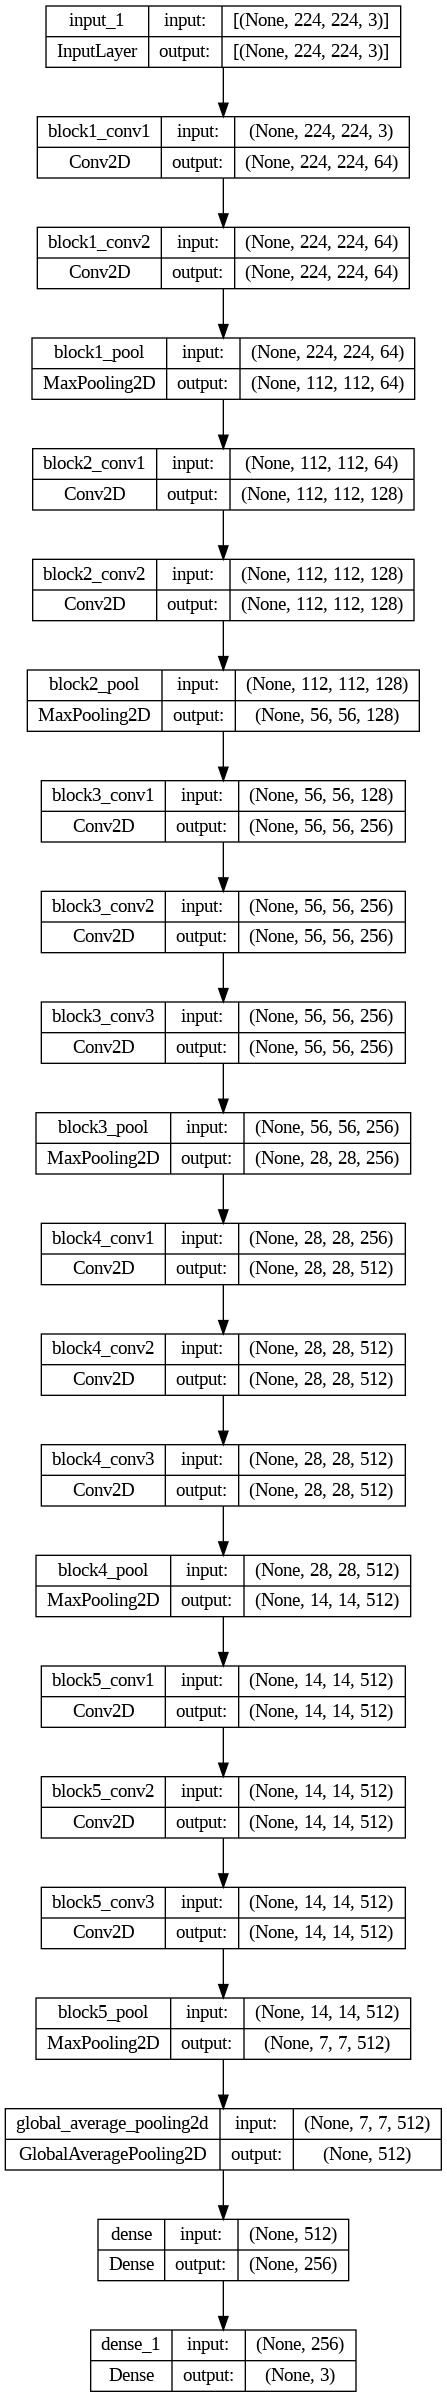

In [ ]:
from IPython.display import Image
# Display the model architecture in the notebook
Image(filename='model_architecture.png')

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model with reduced epochs
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the trained model
model.save('model.keras')

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9086

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 65s 644ms/step - loss: 0.2405 - accuracy: 0.9086 - val_loss: 0.0722 - val_accuracy: 0.9755
Epoch 2/10
92/92 [==============================] - 57s 614ms/step - loss: 0.1051 - accuracy: 0.9609 - val_loss: 0.0729 - val_accuracy: 0.9673
Epoch 3/10
92/92 [==============================] - 63s 682ms/step - loss: 0.1225 - accuracy: 0.9524 - val_loss: 0.0433 - val_accuracy: 0.9823
Epoch 4/10
92/92 [==============================] - 58s 632ms/step - loss: 0.0877 - accuracy: 0.9674 - val_loss: 0.0526 - val_accuracy: 0.9810
Epoch 5/10
92/92 [==============================] - 57s 616ms/step - loss: 0.0525 - accuracy: 0.9813 - val_loss: 0.0629 - val_accuracy: 0.9810
Epoch 6/10
92/92 [==============================] - 59s 641ms/step - loss: 0.0516 - accuracy: 0.9813 - val_loss: 0.0523 - val_accuracy: 0.9769


In [6]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

23/23 [==============================] - 12s 523ms/step - loss: 0.0403 - accuracy: 0.9850
Validation Loss: 0.040337346494197845
Validation Accuracy: 0.9850339889526367


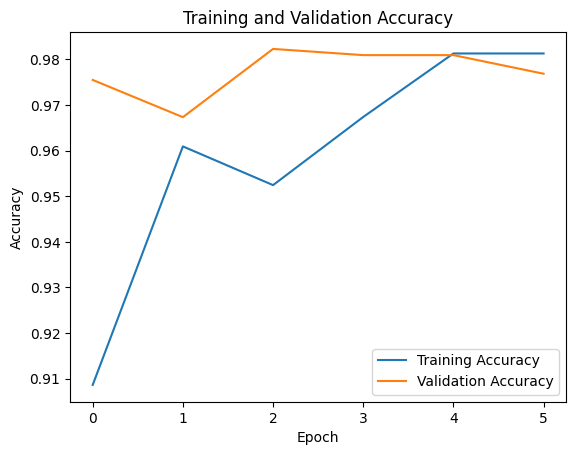

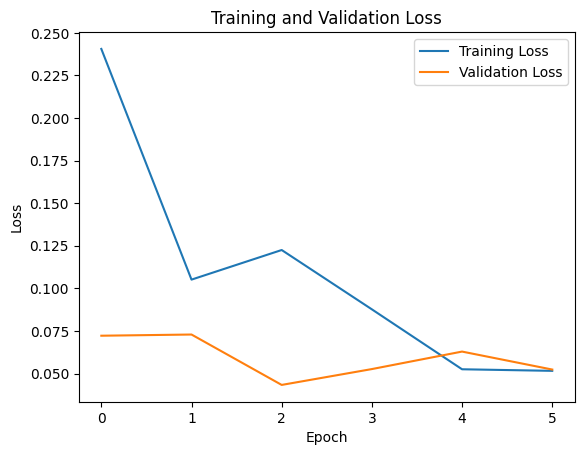

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

23/23 [==============================] - 15s 545ms/step


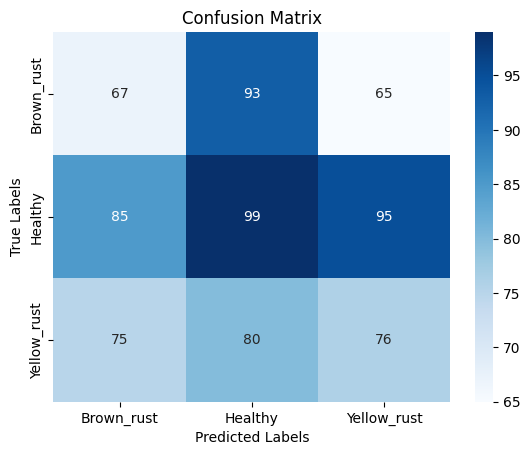

              precision    recall  f1-score   support

  Brown_rust       0.30      0.30      0.30       225
     Healthy       0.36      0.35      0.36       279
 Yellow_rust       0.32      0.33      0.33       231

    accuracy                           0.33       735
   macro avg       0.33      0.33      0.33       735
weighted avg       0.33      0.33      0.33       735



In [8]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reset the validation generator and predict the classes
val_generator.reset()
preds = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))


In [9]:
# Save the trained model in the native Keras format
model.save('model.keras')